In [55]:
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os


In [10]:
os.getcwd()

'/home/dices/Research/GWlensing_Brian'

In [64]:
# --- Step 0: Load the ensemble of lens potential maps ---
# File pattern for Abell 2744 Williams maps (psi maps)
# --- Define the path to your data folder ---
name = "abell370"
data_path = f"/home/dices/Research/range/{name}"  # change this to the actual path where your FITS files are located

# --- Build the file pattern using os.path.join ---
file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_williams-map???_v4_psi.fits")
file_list = sorted(glob.glob(file_pattern))
N_files = len(file_list)
print(f"Found {N_files} FITS files.")
# Define dimensions (given: 678x678)
H, W = 749,749

# Pre-allocate an array for the potentials: shape (N_files, H, W)
potentials = np.empty((N_files, H, W))

for i, filename in enumerate(file_list):
    data = fits.getdata(filename)
    if data.shape != (H, W):
        raise ValueError(f"File {filename} has shape {data.shape}, expected ({H}, {W})")
    potentials[i] = data


Found 40 FITS files.


Upper bound relative uncertainty in lens potential: 2.42%
Upper bound relative uncertainty in deflection angles: 10.33%


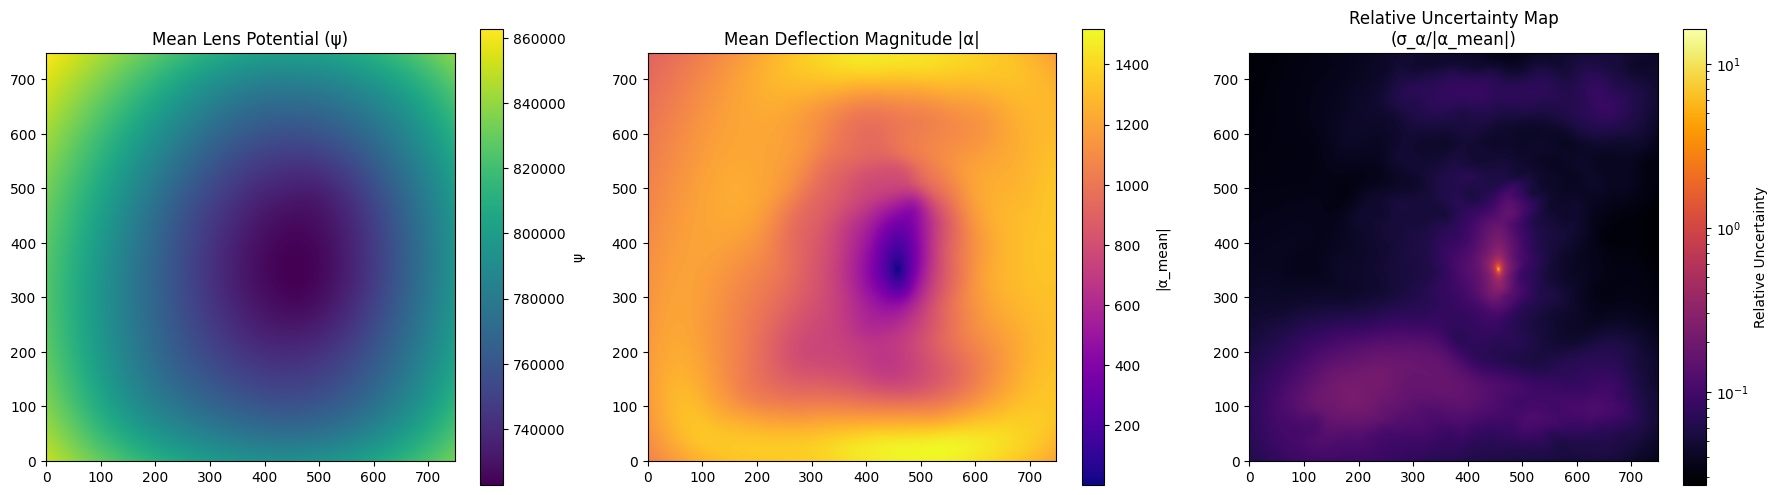

Upper bound relative uncertainty in α_x: 16.16%
Upper bound relative uncertainty in α_y: 30.36%


In [65]:
# --- Step 1: Compute mean and standard deviation for the lens potential maps ---
phi_mean = np.mean(potentials, axis=0)
phi_std  = np.std(potentials, axis=0, ddof=1)  # sample standard deviation
# Compute relative uncertainty for the lens potential:
# Use the absolute value of the mean potential to avoid division by zero.
phi_mean_abs = np.abs(phi_mean)
phi_mean_abs[phi_mean_abs == 0] = 1e-10  # avoid division by zero
rel_uncertainty_phi = phi_std / phi_mean_abs

# Compute an overall upper bound uncertainty by taking the 84th percentile.
upper_bound_fraction_phi = np.percentile(rel_uncertainty_phi, 84)
upper_bound_percentage_phi = upper_bound_fraction_phi * 100
print(f"Upper bound relative uncertainty in lens potential: {upper_bound_percentage_phi:.2f}%")
# --- Step 2: Compute deflection maps (alpha = gradient of psi) ---
# Define pixel scales (adjust dx and dy to your units, e.g., arcsec per pixel)
dx = 0.25  # adjust as needed
dy = 0.25  # adjust as needed

def compute_deflection(potential, dx, dy):
    # np.gradient returns [dψ/dy, dψ/dx] for a 2D array.
    dpsi_dy, dpsi_dx = np.gradient(potential, dy, dx)
    # Return a two-channel array: first channel for x-component, second for y-component.
    return np.stack((dpsi_dx, dpsi_dy), axis=-1)

# plot the x and y components of the deflection angle
deflection = compute_deflection(phi_mean, dx, dy)



# Calculate deflection maps for each realization.
alpha_maps = np.empty((N_files, H, W, 2))
for i in range(N_files):
    alpha_maps[i] = compute_deflection(potentials[i], dx, dy)

# --- Step 3: Compute ensemble statistics for deflection maps ---
alpha_mean = np.mean(alpha_maps, axis=0)   # shape: (H, W, 2)
alpha_std  = np.std(alpha_maps, axis=0, ddof=1)  # shape: (H, W, 2)

# --- Step 4: Compute relative uncertainty on deflection maps ---
# Compute the magnitude of the mean deflection and its standard deviation.
alpha_mean_mag = np.sqrt(np.sum(alpha_mean**2, axis=-1))
alpha_std_mag  = np.sqrt(np.sum(alpha_std**2, axis=-1))
# Avoid division by zero: set any zero mean magnitudes to a small number.
alpha_mean_mag[alpha_mean_mag == 0] = 1e-10

# Relative uncertainty (per pixel):
relative_uncertainty = alpha_std_mag / alpha_mean_mag

# For an overall upper bound, take the 84th percentile of the relative uncertainty.
upper_bound_fraction = np.percentile(relative_uncertainty, 84)  # fractional units
upper_bound_percentage = upper_bound_fraction * 100

print(f"Upper bound relative uncertainty in deflection angles: {upper_bound_percentage:.2f}%")

# --- Optional: Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im0 = axes[0].imshow(phi_mean, origin='lower', cmap='viridis')
axes[0].set_title("Mean Lens Potential (ψ)")
plt.colorbar(im0, ax=axes[0], label="ψ")

im1 = axes[1].imshow(alpha_mean_mag, origin='lower', cmap='plasma')
axes[1].set_title("Mean Deflection Magnitude |α|")
plt.colorbar(im1, ax=axes[1], label="|α_mean|")

im2 = axes[2].imshow(relative_uncertainty, origin='lower', cmap='inferno', norm=LogNorm())
axes[2].set_title("Relative Uncertainty Map\n(σ_α/|α_mean|)")
plt.colorbar(im2, ax=axes[2], label="Relative Uncertainty")

plt.tight_layout()
plt.show()

# Extract x and y components of the ensemble mean and std
alpha_mean_x = alpha_mean[:, :, 0]
alpha_std_x  = alpha_std[:, :, 0]

alpha_mean_y = alpha_mean[:, :, 1]
alpha_std_y  = alpha_std[:, :, 1]

# Avoid division by zero: if a mean component is zero, set it to a small value.
alpha_mean_x_safe = np.where(np.abs(alpha_mean_x) < 1e-10, 1e-10, alpha_mean_x)
alpha_mean_y_safe = np.where(np.abs(alpha_mean_y) < 1e-10, 1e-10, alpha_mean_y)

# Compute relative uncertainties (per pixel) for each component:
rel_unc_x = alpha_std_x / np.abs(alpha_mean_x_safe)
rel_unc_y = alpha_std_y / np.abs(alpha_mean_y_safe)

# Compute an overall upper bound uncertainty (e.g., the 84th percentile) for each component:
upper_bound_rel_unc_x = np.percentile(rel_unc_x, 84) * 100  # as a percentage
upper_bound_rel_unc_y = np.percentile(rel_unc_y, 84) * 100  # as a percentage

print(f"Upper bound relative uncertainty in α_x: {upper_bound_rel_unc_x:.2f}%")
print(f"Upper bound relative uncertainty in α_y: {upper_bound_rel_unc_y:.2f}%")